# Local Hill Climb

Local Hill Climb search algorithm implemented in a discrete environment.


In [1]:
import sys, os

sys.path.insert(0, os.path.join(os.getcwd(), "../src")) # run from within examples folder

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger
from typing import List, Tuple
from copy import copy

In [3]:
# Install from package at https://github.com/iwishiwasaneagle/jsim/releases/latest
from jsim.Simulation import Simulation
from jsim.Agent import Agent
from jsim.Environment import Environment
from jsim.Meta import Action, State

In [4]:
class XYState(State):
    def __init__(self,x:float=0,y:float=0) -> None:
        self.x = x
        self.y = y
    
    def __str__(self) -> str:
        return f"{type(self).__name__}({self.x}, {self.y})"

class Position(XYState):
    pass

In [5]:
class VicinityPDM(State):
    def __init__(self, vicinity: List) -> None:
        """
        A slice of the PDM centered at the agent's location

        -------------
        | 0 | 1 | 2 |
        | - | - | - |
        | 3 | 4 | 5 |
        | - | - | - |
        | 6 | 7 | 8 |
        -------------    

        :param vicinity: The PDM values in the 3x3 area around the agent
        :type vicinity: List
        """
        assert len(vicinity) == 9
        self._vicinity = vicinity

    def __len__(self):
        return len(self._vicinity)

    def __getitem__(self, idx):
        assert idx>=0 and idx<=8
        assert isinstance(idx,int)

        return self._vicinity[idx]

    def __iter__(self):
        if not hasattr(self, '_c'):
            self._c = -1
        return self

    def __next__(self):
        self._c += 1
        if self._c >= len(self):
            raise StopIteration
        return self._vicinity[self._c]
    
    def __str__(self) -> str:
        return f"{type(self).__name__}({self._vicinity})"

assert max(VicinityPDM([1,2,3,10,5,6,7,8,9])) == 10

In [6]:
class Step(Action):
    def __init__(self, idx:int) -> None:
        self.idx = int(idx)
        lookup = [
            (-1, +1),
            ( 0,  +1),
            ( 1, +1),
            (-1,  1),
            ( 0,  1),
            ( 1,  1),
            (-1, -1),
            ( 0, -1),
            ( 1, -1),
            ]
        self.rel_x, self.rel_y = lookup[self.idx]
    
    def __str__(self) -> str:
        return f"{type(self).__name__}({self.rel_x},{self.rel_y})"

In [7]:
class PDMEnv(Environment):
    def __init__(self, N:int=16, psim: Simulation = None) -> None:
        super().__init__(psim=psim)

        self.size = (N,N)

        self.pdm = self._generate_pdm()

    def _generate_pdm(self, N:int=5):
        x, y = np.meshgrid(np.arange(self.size[0]), np.arange(self.size[1]))

        pdm = np.zeros(self.size)

        for _ in range(N): # Generate N gaussians
            A = max(np.random.rand()*2,1)
            a = np.random.rand()*0.03
            b = 0
            c = np.random.rand()*0.03
            x0 = np.random.uniform(0,self.size[0]) # Centre of gaussian
            y0 = np.random.uniform(0,self.size[1])
            
            pdm += A*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
                
        return pdm

    def _get_vicinity_at_xy(self,x:int,y:int):
        vicinity = np.empty(9)

        for idx,ij in enumerate([
                                (x-1,y+1),
                                (x,  y+1),
                                (x+1,y+1),
                                (x-1,y),
                                (x,  y),
                                (x+1,y),
                                (x-1,y-1),
                                (x,  y-1),
                                (x+1,y-1),
                                ]):
            i,j = ij
            # Todo: does i corresponds to shape[0] or shape[1]?
            if i<0 or j<0 or i>=self.pdm.shape[0] or j>=self.pdm.shape[1]: 
                vicinity[idx] = -np.iinfo(np.int16).max
            else:
                vicinity[idx] = self.pdm[j][i]
        return vicinity

    def reset(self, agent_p:Position) -> Position:
        self.pdm = self._generate_pdm()

        vicinity = self._get_vicinity_at_xy(agent_p.x, agent_p.y)

        return vicinity

    def step(self, agent_s: Position) -> Tuple[VicinityPDM, float]:
        assert agent_s.x >=0 and agent_s.y>=0

        reward = self.pdm[agent_s.y][agent_s.x]
        self.pdm[agent_s.y][agent_s.x] = -1 # Todo: adjust this

        env_s = self._get_vicinity_at_xy(agent_s.x,agent_s.y)

        return env_s, reward

In [8]:
class LHCAgent(Agent):
    def __init__(self, penv: Environment = None) -> None:
        self.penv = penv

    def policy(self, pnext_s: VicinityPDM) -> Step:
        idx = np.argmax(copy(pnext_s))
        return Step(idx)

    def step(self, pnext_s: VicinityPDM) -> Step:
        return self.policy(pnext_s)

    def update(self, pa: Step) -> Position:
        if not hasattr(self,'state'):
            logger.error(f"Reset has not been called as {hasattr(self,'state')=}")
            raise Exception

        self.state.x += pa.rel_x
        self.state.y += pa.rel_y

        return copy(self.state)
        
    def reset(self, ps: Position, vicinity: VicinityPDM) -> Tuple[Step, Position]:
        self.state = copy(ps)
        return self.policy(vicinity), self.state

In [9]:
class LHCSim(Simulation):
    agent: LHCAgent
    env: PDMEnv

    def __init__(self, initial_pos=Position(), dt=0.1) -> None:
        self.env = PDMEnv(16,self)
        self.agent = LHCAgent(self.env)
        self.dt = dt

        self.initial_agent_s = initial_pos

        self.data_store = {'env_s':[],'agent_s':[],'agent_a':[],'reward':[]}
        super().__init__()

    def reset(self) -> None:
        self.vicinity_pdm = self.env.reset(self.initial_agent_s)
        self.agent_a, self.agent_s = self.agent.reset(self.initial_agent_s,self.vicinity_pdm)
        self.data_store = {'env_s':[],'agent_s':[],'agent_a':[],'reward':[]}

    def steps(self, num_steps: int) -> None:
        self.reset()

        for _ in range(num_steps):
            vicinity_pdm, reward = self.env.step(self.agent_s)

            self.collect_data(vicinity_pdm, self.agent_a, self.agent_s, reward)

            agent_a = self.agent.step(vicinity_pdm)

            agent_s = self.agent.update(agent_a)

            self.agent_s = agent_s
            self.agent_a = agent_a
            self.vicinity_pdm = vicinity_pdm
            
        logger.info(f"Maximum number of steps={num_steps} reached")
                

    def collect_data(self, env_s: VicinityPDM, agent_a: Step, agent_s: Position, reward: float) -> None:
        self.data_store['env_s'].append(copy(env_s))
        self.data_store['agent_a'].append(copy(agent_a))
        self.data_store['agent_s'].append(copy(agent_s))
        self.data_store['reward'].append(copy(reward))
            
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(8, 6), dpi=80)

        # Reward over time
        t = [t*self.dt for t in range(len(self.data_store['env_s']))]
        ax1.plot(t,np.cumsum(self.data_store['reward']))
        ax1.set_ylabel('Cumulative reward')
        ax1.set_xlabel('time (s)')

        # Show pdm and path
        x = [p.x+0.5 for p in self.data_store['agent_s']]
        y = [p.y+0.5 for p in self.data_store['agent_s']]
        
        pdm = self.env.pdm

        ax2.imshow(pdm, origin='lower', extent=[0, pdm.shape[0], 0, pdm.shape[1]])
        ax2.plot(x,y)
        ax2.scatter(x[0],y[0],label='Start')
        ax2.scatter(x[-1],y[-1],label='End')
        ax2.set_ylabel('y')
        ax2.set_xlabel('x')
        ax2.legend()

        fig.tight_layout()

2021-12-20 11:15:17.815 | INFO     | __main__:steps:36 - Maximum number of steps=30 reached


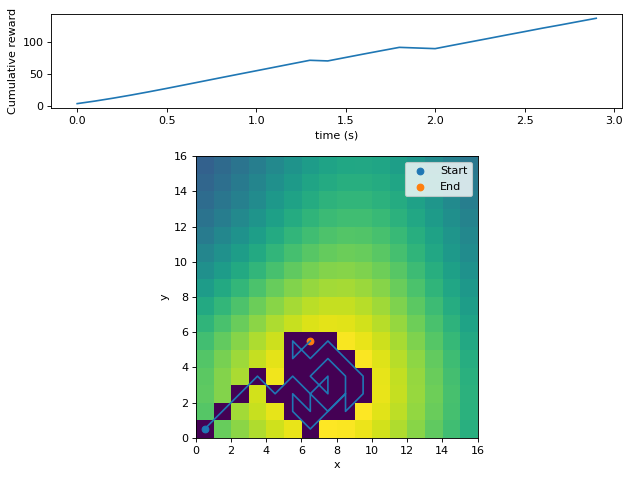

In [10]:
sim = LHCSim()

sim.steps(30)
sim.plot()